In [35]:
# !pip install scikit-learn
# !pip install matplotlib
# !pip install tqdm

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import json
from sklearn.metrics import f1_score
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import torch.nn.functional as F


In [2]:
with open('/Users/nalishjain/Acad Sem 6/NLP-Assignments/A4_16/train_dict.pkl', 'rb') as f:
    train_data = pickle.load(f, encoding='latin1')

with open('/Users/nalishjain/Acad Sem 6/NLP-Assignments/A4_16/val_dict.pkl', 'rb') as f:
    val_data = pickle.load(f, encoding='latin1')
    
with open('/Users/nalishjain/Acad Sem 6/NLP-Assignments/A4_16/val_dict.pkl', 'rb') as f:
    val_without_pad =  pickle.load(f, encoding='latin1')

emotion_ids = {'neutral' : 0, 'joy' : 1, 'anger' : 2, 'surprise' : 3, 'sadness' : 4, 'fear' : 5, 'disgust' : 6}

In [3]:
train_data[0][2]

['surprise', 'fear', 'surprise', 'sadness', 'disgust']

In [4]:
def pad_data():
    max_length = 25
    pad_word = 'PAD'
    pad_emotion = 'neutral'
    data = [train_data, val_data]
    dict_ = {}

    for task_data in data:
        remove_keys = []
        for key in task_data:
            if len(task_data[key][0]) not in dict_:
                dict_[len(task_data[key][0])] = 0
            dict_[len(task_data[key][0])] += 1
            # checking_nan
            for step in range(len(task_data[key][3])):
                if task_data[key][3][step] is None:
                    remove_keys.append(key)
                    print(key)
            for step in range(len(task_data[key][0]), max_length):
                task_data[key][0].append(pad_word)
                task_data[key][1].append(np.zeros(768))
                task_data[key][2].append(pad_emotion)
                task_data[key][3].append(0)
        
        for key in remove_keys:
            if key in task_data:
                del task_data[key] 

def remove_nan():
    # max_length = 25
    # pad_word = 'PAD'
    # pad_emotion = 'neutral'
    data = [val_without_pad]
    dict_ = {}

    for task_data in data:
        remove_keys = []
        for key in task_data:
            if len(task_data[key][0]) not in dict_:
                dict_[len(task_data[key][0])] = 0
            dict_[len(task_data[key][0])] += 1
            # checking_nan
            for step in range(len(task_data[key][3])):
                if task_data[key][3][step] is None:
                    remove_keys.append(key)
                    print(key)
            # for step in range(len(task_data[key][0]), max_length):
            #     task_data[key][0].append(pad_word)
            #     task_data[key][1].append(np.zeros(768))
            #     task_data[key][2].append(pad_emotion)
            #     task_data[key][3].append(0)
        
        for key in remove_keys:
            if key in task_data:
                del task_data[key]  
    # print(dict_)

pad_data()
remove_nan()
train_data = {new_key: train_data[old_key] for new_key, (old_key, _) in enumerate(train_data.items())}
val_data = {new_key: val_data[old_key] for new_key, (old_key, _) in enumerate(val_data.items())}
val_without_pad = {new_key: val_without_pad[old_key] for new_key, (old_key, _) in enumerate(val_without_pad.items())}


492
628
676
1240
1308
1642
3257
3368
3764
4177
175
378
504
528
175
378
504
528


In [5]:
print(len(train_data))

4170


In [6]:

    
class GRUModel_emotions(nn.Module):
    def __init__(self, embedding_dim, output_size):
        super(GRUModel_emotions, self).__init__()
        self.gru1 = nn.GRU(embedding_dim, 256, num_layers=1, batch_first=True)
        self.gru2 = nn.GRU(256, 64, num_layers=1, batch_first=True)
        # self.gru3 = nn.GRU(128, 64, num_layers=1, batch_first=True)
        self.gru4 = nn.GRU(64, 32, num_layers=1, batch_first=True)
        self.one_hot_projection = nn.Linear(7, 16)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, output_size)

    def forward(self, x, emotions):
        out, _ = self.gru1(x)
        out, _ = self.gru2(out)
        # out, _ = self.gru3(out)
        out, _ = self.gru4(out)
        out = self.fc1(out) 
        out += self.one_hot_projection(emotions.float()) #Fusing emotions
        out = self.fc2(out)      
        return out

class ErfDataset(Dataset):
    def __init__(self, data, emo_index):
        self.data = data
        self.length = len(self.data)
        self.emo_index =  emo_index

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        sentence_embeddings = np.array(self.data[index][1] , dtype='float32')
        emotion_sequence = self.data[index][2]
        # print(emotion_sequence)
        emotion_labels = [self.emo_index[emotion] for emotion in emotion_sequence]
        output_labels = np.array(self.data[index][3], dtype='float32')
        return torch.tensor(sentence_embeddings, dtype= torch.float32), torch.tensor(emotion_labels), torch.tensor(output_labels, dtype= torch.float32)

In [7]:
train_dataset = ErfDataset(train_data, emotion_ids)
val_dataset = ErfDataset(val_data, emotion_ids)
val_without_pad_dataset = ErfDataset(val_without_pad, emotion_ids)

In [8]:
one_hot_emotions = F.one_hot(train_dataset[0][1], num_classes=7)
one_hot_emotions

tensor([[0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0]])

In [9]:
def train_model(train_dataset, val_dataset, model, optimizer, criterion, device,  num_epochs = 30, batch_size = 32):
    test_dataloader = None

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader =  DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    print(len(train_dataloader))

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0
        all_train_predictions = []
        all_train_targets = []

        for batch_idx, (inputs, emotions, targets) in enumerate(train_dataloader):
            one_hot_emotions = F.one_hot(emotions, num_classes=7)
            # print(batch_idx, "\\", len(train_dataloader))
            inputs, one_hot_emotions, targets = inputs.to(device), one_hot_emotions.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, one_hot_emotions)
            
            loss = 0

            for i in range(outputs.size(1)):  # Iterate over time steps
                # print(type(outputs[:, i, :]))
                loss += criterion(outputs[:, i, :], targets[:, i].long())  
            
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            all_train_predictions.extend(outputs.argmax(dim=2).view(-1).cpu().numpy())
            all_train_targets.extend(targets.view(-1).cpu().numpy())

        print(np.sum(np.array(all_train_predictions)), np.sum(np.array(all_train_targets)), len(all_train_targets))

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        # return all_train_targets
        train_macro_f1 = f1_score(all_train_targets, all_train_predictions, average='weighted')
        train_f1_scores.append(train_macro_f1)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}, Training Macro F1-Score: {train_macro_f1}")

        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        all_val_predictions = []
        all_val_targets = []

        with torch.no_grad():
            for val_inputs, val_emotions, val_targets in val_dataloader:
                one_hot_emotions = F.one_hot(val_emotions, num_classes=7)
                val_inputs, one_hot_emotions, val_targets = val_inputs.to(device), one_hot_emotions.to(device), val_targets.to(device)
                val_outputs = model(val_inputs, one_hot_emotions)

                loss = 0
                for i in range(val_outputs.size(1)):  # Iterate over time steps
                    loss += criterion(val_outputs[:, i, :], val_targets[:, i].long())  

                total_val_loss += loss.item()

                all_val_predictions.extend(val_outputs.argmax(dim=2).view(-1).cpu().numpy())
                all_val_targets.extend(val_targets.view(-1).cpu().numpy())

            avg_val_loss = total_val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)

            val_macro_f1 = f1_score(all_val_targets, all_val_predictions, average='weighted')
            val_f1_scores.append(val_macro_f1)
        print(f"Epoch {epoch + 1},  Validation Loss: {avg_val_loss}, Validation Macro F1-Score: {val_macro_f1}")
    plot_results(train_losses, val_losses, train_f1_scores, val_f1_scores)

    return train_losses, train_f1_scores, val_losses, val_f1_scores

def plot_results(train_losses, val_losses, train_f1_scores, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Macro F1-Scores
    # plt.subplot(1, 2, 2)
    # plt.plot(epochs, train_f1_scores, label='Training Macro F1-Score')
    # plt.plot(epochs, val_f1_scores, label='Validation Macro F1-Score')
    # plt.title('Training and Validation Macro F1-Scores')
    # plt.xlabel('Epochs')
    # plt.ylabel('Macro F1-Score')
    # plt.legend()

    # plt.tight_layout()
    plt.show()


def test_model(test_dataset, model, device):
    test_dataloader = None
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


    total_test_loss = 0
    all_test_predictions = []
    all_test_targets = []

    with torch.no_grad():
        for test_inputs, test_emotions, test_targets in test_dataloader:
            one_hot_emotions = F.one_hot(test_emotions, num_classes=7)
            test_inputs, one_hot_emotions, test_targets = test_inputs.to(device), one_hot_emotions.to(device), test_targets.to(device)
            test_outputs = model(test_inputs, one_hot_emotions)

            all_test_predictions.extend(test_outputs.argmax(dim=2).view(-1).cpu().numpy())
            all_test_targets.extend(test_targets.view(-1).cpu().numpy())

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_macro_f1 = f1_score(all_test_targets, all_test_predictions, average='weighted')
    print(f'Test Macro F1-Score: {test_macro_f1}')

/Users/nalishjain/Acad Sem 6/NLP-Assignments/A4_16/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


131
1763 5738.0 104250
Epoch 1, Training Loss: 12.76825776718955, Training Macro F1-Score: 0.9166051285534151
Epoch 1,  Validation Loss: 8.817686062592726, Validation Macro F1-Score: 0.9054405595377928
18189 5738.0 104250
Epoch 2, Training Loss: 8.155754329594037, Training Macro F1-Score: 0.8772498346230415
Epoch 2,  Validation Loss: 7.821786953852727, Validation Macro F1-Score: 0.862225663502466
20732 5738.0 104250
Epoch 3, Training Loss: 7.520796422739975, Training Macro F1-Score: 0.867936965352096
Epoch 3,  Validation Loss: 7.431150949918306, Validation Macro F1-Score: 0.8639784596620587
20024 5738.0 104250
Epoch 4, Training Loss: 7.242321414801911, Training Macro F1-Score: 0.8711665715582658
Epoch 4,  Validation Loss: 7.295000296372634, Validation Macro F1-Score: 0.8766856297821851
19041 5738.0 104250
Epoch 5, Training Loss: 7.098882689730812, Training Macro F1-Score: 0.8760003149709674
Epoch 5,  Validation Loss: 7.011577496161828, Validation Macro F1-Score: 0.8848387451415437
1856

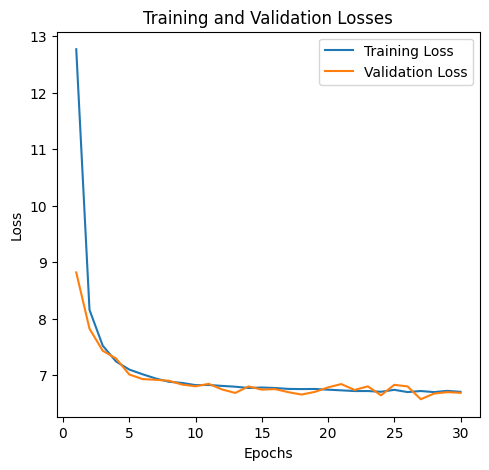

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GRUModel_emotions(768, 2).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.05,6.16]))

train_losses, train_f1_scores, val_losses, val_f1_scores = train_model(train_dataset, val_dataset, model = model, num_epochs = 30, optimizer=optimizer, criterion=criterion, batch_size=32, device=device)
# torch.save(model.state_dict(), 'model_4_dict.pt')




In [11]:
loaded_model = GRUModel_emotions(768, 2)
loaded_model.load_state_dict(torch.load('model_4_dict.pt'))
test_model(val_without_pad_dataset, loaded_model, device)

Test Loss: 0.0, Test Macro F1-Score: 0.6880068166184801
